<a href="https://colab.research.google.com/github/kheya19367/Bollywood_Trends_Analysis/blob/main/Bollywood_Analysis_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#required installations
!pip install wikipedia
!pip install wikipedia-api
!pip install transformers accelerate bitsandbytes -q

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=3b0fbcaf303ce47ae24e250b78ee5c11ae5001ea543f2846fe1a9a7e86bde133
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=28aed6dbb77a98d4ebd0965d091fa4ba68b2dbd8214af8f30aa1f7ead013aea2
  Stored in directory: /root/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00
   ━━━

In [2]:
#setting up libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import wikipedia
import time
import urllib.parse
import re
import os
from google.colab import userdata
import json
import torch
from transformers import pipeline
import asyncio
import aiohttp
import wikipediaapi
import seaborn as sns
import matplotlib.pyplot as plt


os.environ['TMDB_TOKEN'] = userdata.get("TMDB-READ-ACCESS-TOKEN")
os.environ['GROQ_API_KEY'] = userdata.get("GROQ_API_KEY")
os.environ['OMDB_API_KEY'] = userdata.get("OMDB_API_KEY")

In [3]:
wikipedia.set_lang("en") #seting the for wikipedia language to english


In [4]:
df_movie_sample = pd.read_csv("sampled_100_movies.csv")

#Movie Material Collection

In [5]:
movie_title = df_movie_sample['title_x']

Authenticate For TMDB

In [6]:
def authenticate():
  url = "https://api.themoviedb.org/3/authentication"
  headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {os.environ['TMDB_TOKEN']}"
  }
  response = requests.get(url, headers=headers)
  if json.loads(response.text)['success']: return
  raise Exception("Authentication failed")

Extracting Movie Synopsis From Wikipedia and TMDB

In [7]:
def extract_plot_from_wikipedia(wiki_url):
    headers = {
        'User-Agent': 'Mozilla/5.0'
    }

    try:
        response = requests.get(wiki_url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        # More robust search for the 'Plot' section
        plot_heading = soup.find(id='Plot')
        if not plot_heading:
          plot_heading = soup.find(id='Synopsis')

        if not plot_heading:
            #print(f"No plot section found in: {wiki_url}")
            return None

        # Get the text between this header and the next header
        content = []
        for sibling in plot_heading.parent.find_next_siblings():
            if sibling.name == 'h2':
                break
            if sibling.name == 'p':
                text = sibling.get_text(" ", strip=True)
                if text:
                    content.append(text)

        plot_text = "\n\n".join(content).strip()

        return plot_text if plot_text else None

    except Exception as e:
        #print(f"Error fetching from {wiki_url}: {e}")
        return None

In [8]:
def search_wikipedia_url(title):
    base_url = "https://en.wikipedia.org/wiki/"
    formatted_title = urllib.parse.quote(title.replace(" ", "_"))
    return base_url + formatted_title

In [9]:
plots_data = []
for index, row in df_movie_sample.iterrows():
    title = row['title_x']
    imdb_id = row['imdb_id']
    wiki_link = row["wiki_link"]
    plot = extract_plot_from_wikipedia(wiki_link)
    plots_data.append({'title_x': title, 'imdb_id': imdb_id, 'plot': plot})

df_plots = pd.DataFrame(plots_data)
#display(df_plots.head())

Find Movie Plot from TMDB

In [10]:
def get_movie_overview(movie_name):
  movie_id = search_movie(movie_name)
  if movie_id is None:
    return None
  movie_data = get_movie_data(movie_id)
  return movie_data['overview']

Find Movie Poster from TMDB

In [11]:
def search_movie(movie_name):
  response = requests.get(
    url = f"https://api.themoviedb.org/3/search/movie?query={movie_name}",
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {os.environ['TMDB_TOKEN']}"
    }
  )
  movie_data = json.loads(response.text)
  movie_id = None
  for result in movie_data['results']:
    if result['title'] == movie_name:
      movie_id = result['id']
      return movie_id
  return None


def get_movie_data(movie_id):
  response = requests.get(
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?language=en-US",
    headers = {
      "accept": "application/json",
      "Authorization": f"Bearer {os.environ['TMDB_TOKEN']}"
    }
  )
  movie_data = json.loads(response.text)
  return movie_data


def construct_poster_url(poster_path):
  # getting the base_url and image size from the configurations API
  response = requests.get(
      url = "https://api.themoviedb.org/3/configuration",
      headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {os.environ['TMDB_TOKEN']}"
      }
  )

  config_data = json.loads(response.text)
  base_url = config_data['images']['base_url']
  # selecting the 3rd smallest size
  poster_size = config_data['images']['poster_sizes'][2]
  return f"{base_url}{poster_size}{poster_path}"



def get_movie_poster(movie_name):
  movie_id = search_movie(movie_name)
  if movie_id is None:
    return None
  movie_data = get_movie_data(movie_id)
  poster_path = movie_data['poster_path']
  poster_url = construct_poster_url(poster_path)
  return poster_url


COLLECTING ALL MOVIE SYNOPSIS

In [12]:
def get_plot(row):
    if pd.notna(row['plot']):
        return row['plot']
    else:
        movie_title = row['title_x']
        story = df_movie_sample.loc[df_movie_sample['title_x'] == movie_title, 'story'].iloc[0]
        if pd.notna(story):
            return story
        else:
            summary = df_movie_sample.loc[df_movie_sample['title_x'] == movie_title, 'summary'].iloc[0]
            if pd.notna(summary):
                return summary
            else:
                return get_movie_overview(movie_title)

df_plots['plot'] = df_plots.apply(get_plot, axis=1)
#display(df_plots)

Collecting all Movie Posters

In [13]:
movie_poster = df_movie_sample[['title_x']].copy()

def get_poster(row):
    if pd.notna(row['poster_path']) and row['poster_path'] != '':
        return row['poster_path']
    else:
        return get_movie_poster(row['title_x'])

movie_poster['movie_poster'] = df_movie_sample.apply(get_poster, axis=1)
#display(movie_poster)

In [14]:
# Create the "data" directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

df_plot_poster = pd.merge(df_plots, movie_poster, on='title_x')
df_plot_poster.to_csv('data/data.csv', index=False)
#display(df_plot_poster.head())

#DESCRIPTIVE METADATA

Scraping Gender of Director

In [15]:
gender_cache = {}

async def get_gender_async(session, name):
    name = name.strip()

    # Return from cache if already found
    if name in gender_cache:
        return gender_cache[name]

    # --- Try Wikipedia first ---
    try:
        async with session.get(f"https://en.wikipedia.org/api/rest_v1/page/summary/{name}") as response:
            if response.status == 200:
                data = await response.json()
                text = data.get("extract", "").lower()
                if " she " in text or " her " in text:
                    gender_cache[name] = "female"
                    return "female"
                elif " he " in text or " his " in text:
                    gender_cache[name] = "male"
                    return "male"
    except Exception as e:
        print(f"Error fetching from Wikipedia for {name}: {e}")

    # --- Fallback to genderize.io ---
    first_name = name.split()[0]
    try:
        async with session.get(f"https://api.genderize.io?name={first_name}") as response:
            if response.status == 200:
                data = await response.json()
                gender = data.get("gender", "unknown")
                gender_cache[name] = gender or "unknown"
                return gender or "unknown"
    except Exception as e:
        print(f"Error for {name}: {e}")

    # Default fallback
    gender_cache[name] = "unknown"
    return "unknown"

async def annotate_director_genders_async(df, column_name='directors_name'):
    # Get all unique director names
    all_directors = set(d.strip() for directors in df[column_name] for d in directors.split('|'))

    async with aiohttp.ClientSession() as session:
        tasks = [get_gender_async(session, name) for name in all_directors]
        await asyncio.gather(*tasks)

    # Map back to DataFrame
    def annotate_row(directors_str):
        return '|'.join([f"{d.strip()} ({gender_cache.get(d.strip(), 'unknown')})" for d in directors_str.split('|')])

    df['Director_Genders'] = df[column_name].apply(annotate_row)
    return df

Adding Gender to Data Frame

In [16]:
df_movie_sample = await annotate_director_genders_async(df_movie_sample)
#display(df_movie_sample.head())

Summary Table and Plot for Director's Gender

,Gender,Count
0,male,86
1,female,12
2,unknown,2


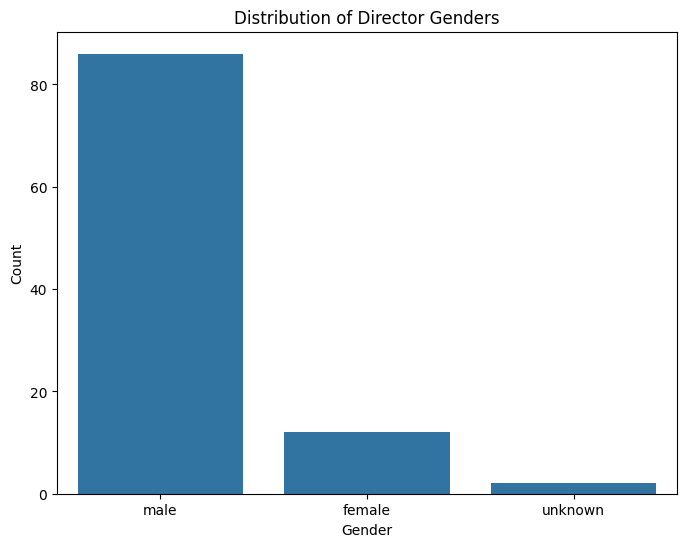

In [17]:
# Extract the gender from the 'Director_Genders' column
df_movie_sample['gender'] = df_movie_sample['Director_Genders'].apply(lambda x: x.split('(')[-1][:-1] if '(' in x else 'unknown')

# Count the occurrences of each gender
gender_counts = df_movie_sample['gender'].value_counts().reset_index()
gender_counts.columns = ['Gender', 'Count']

# Display the summary table
display(gender_counts)

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Gender', y='Count', data=gender_counts)
plt.title('Distribution of Director Genders')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

GET BOX OFFICE DATA

API Key

In [18]:
OMDB_API_KEY = userdata.get("OMDB_API_KEY")  # Replace with perosnal key for access  key

In [19]:
def get_gross_revenue_from_omdb(imdb_id):
    try:
        url = f"http://www.omdbapi.com/?i={imdb_id}&apikey={OMDB_API_KEY}"
        response = requests.get(url)
        data = response.json()
        return data.get("BoxOffice", None)
    except Exception as e:
        print(f"Error for {imdb_id}: {e}")
        return None

In [20]:
box_office = pd.DataFrame()
box_office[imdb_id] = df_movie_sample['imdb_id'].copy()
box_office['box_office'] = df_movie_sample['imdb_id'].apply(get_gross_revenue_from_omdb)

Summary Plot and Graog for Box Office Data

,box_office_numeric
count,$23.00
mean,"$1,455,452.48"
std,"$1,974,654.65"
min,"$75,929.00"
25%,"$381,906.50"
50%,"$651,096.00"
75%,"$1,516,784.00"
max,"$8,031,955.00"


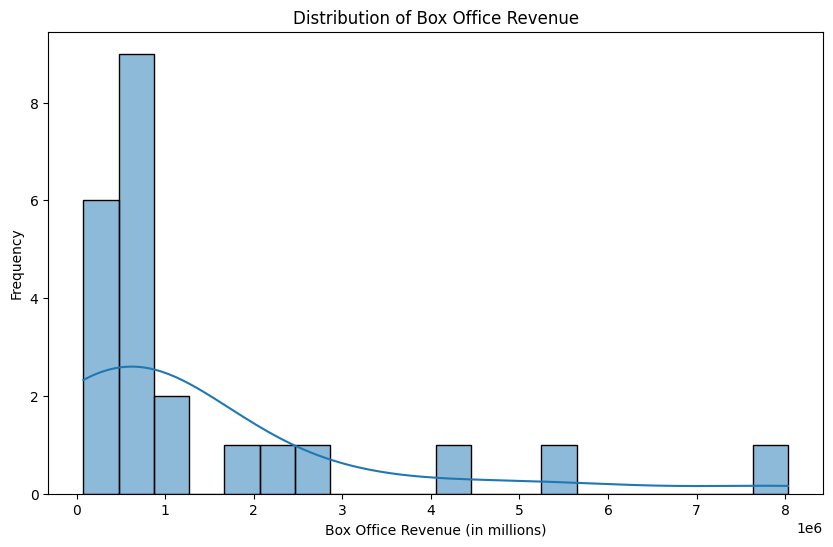

In [21]:
# Clean the 'box_office' column
box_office['box_office_numeric'] = box_office['box_office'].replace({'\$': '', ',': ''}, regex=True)
box_office['box_office_numeric'] = pd.to_numeric(box_office['box_office_numeric'], errors='coerce')

# Create a summary table
box_office_summary = box_office['box_office_numeric'].describe().to_frame()

# Format the summary table
box_office_summary['box_office_numeric'] = box_office_summary['box_office_numeric'].apply(lambda x: f"${x:,.2f}")


display(box_office_summary)

# Create a summary plot
plt.figure(figsize=(10, 6))
sns.histplot(box_office['box_office_numeric'].dropna(), bins=20, kde=True)
plt.title('Distribution of Box Office Revenue')
plt.xlabel('Box Office Revenue (in millions)')
plt.ylabel('Frequency')
plt.show()

#THEMATIC CODING

In [22]:
def analyze_theme_sentiment_llm_batched(plots, candidate_labels, classifier):
    results = []
    for i, plot in enumerate(plots):
        print(f"Processing plot {i+1}/{len(plots)}...")
        try:
            # The zero-shot pipeline handles truncation
            response = classifier(plot, candidate_labels)
            results.append(response['labels'][0])
        except Exception as e:
            print(f"An error occurred while processing plot {i+1}: {e}")
            results.append("Error")

    return results

Using Pre-trained model from HuggingFace

Note : For time effeciency use GPU when running on Google Colab

In [23]:
classifier = pipeline("zero-shot-classification", model="cross-encoder/nli-distilroberta-base")

axes = {
    'hindu_muslim': ['Secular','Exclusionary'],
    'feminist_misogynistic': ['Feminist', 'Misogynistic'],
    'nationalism': ['Tolerant', 'Jingoistic'],
    'caste_dynamics': ['Egalitarian','casteist']
}

for axis_name, labels in axes.items():
    df_plots[f"{axis_name}_llm_label"] = analyze_theme_sentiment_llm_batched(df_plots['plot'].tolist(), labels, classifier)

del classifier
torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Processing plot 1/100...
Processing plot 2/100...
Processing plot 3/100...
Processing plot 4/100...
Processing plot 5/100...
Processing plot 6/100...
Processing plot 7/100...
Processing plot 8/100...
Processing plot 9/100...
Processing plot 10/100...
Processing plot 11/100...
Processing plot 12/100...
Processing plot 13/100...
Processing plot 14/100...
Processing plot 15/100...
Processing plot 16/100...
Processing plot 17/100...
Processing plot 18/100...
Processing plot 19/100...
Processing plot 20/100...
Processing plot 21/100...
Processing plot 22/100...
Processing plot 23/100...
Processing plot 24/100...
Processing plot 25/100...
Processing plot 26/100...
Processing plot 27/100...
Processing plot 28/100...
Processing plot 29/100...
Processing plot 30/100...
Processing plot 31/100...
Processing plot 32/100...
Processing plot 33/100...
Processing plot 34/100...
Processing plot 35/100...
Processing plot 36/100...
Processing plot 37/100...
Processing plot 38/100...
Processing plot 39/10

In [24]:
df_plots = pd.merge(df_plots, df_movie_sample[['imdb_id', 'year_of_release']], on='imdb_id', how='left')
#display(df_plots.head())

In [25]:
df_plots.to_csv('data/classified_data.csv')